# **Analysis of bias-adjusted climatic varible on North Italy**

#### The following Notebook analysis different climate variable produced by different combination of GCM and RCM and bias adjusted with quantile mapping 

## Libraries Import

In [2]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib as mpl

# Folder where file are stored 
data_path = r"C:\Users\Veronica\OneDrive - Politecnico di Milano\POLIMI\SAHARA\prova"

# Temperature

## Mean Temperature

In [3]:
# Data load
rcp26_files = sorted(glob.glob(f"{data_path}\*tas*rcp26*.nc"))
rcp45_files = sorted(glob.glob(f"{data_path}\*tas*rcp45*.nc"))
rcp85_files = sorted(glob.glob(f"{data_path}\*tas*rcp85*.nc"))

obs = sorted(glob.glob(f"{data_path}\*E-OBS*mean_temp*.nc")) # Observation data

In [5]:
ds_rcp26 = xr.open_mfdataset(
    rcp26_files,
    combine='by_coords',
    #chunks={"time": 1825}   
)

ds_rcp45 = xr.open_mfdataset(
    rcp45_files,
    combine='by_coords',
    #chunks={"time": 1825}
)

ds_rcp85 = xr.open_mfdataset(
    rcp85_files,
    combine='by_coords',
    #chunks={"time": 1825}
)

ds_obs = xr.open_mfdataset(
    obs,
    combine='by_coords',
    #chunks={"time": 1825}
)

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [7]:
# Mean on spatial domain (lat e lon)
tas_spatial_mean_26 = ds_rcp26["tas"].mean(dim=["y","x"])
tas_spatial_mean_45 = ds_rcp45["tas"].mean(dim=["y","x"])
tas_spatial_mean_85 = ds_rcp85["tas"].mean(dim=["y","x"])
tas_spatial_mean_obs = ds_obs["tg"].mean(dim=["Easting","Northing"])

# Annual Mean
tas_annual_mean_26 = tas_spatial_mean_26.resample(time="1Y").mean() -273.15
tas_annual_mean_45 = tas_spatial_mean_45.resample(time="1Y").mean() -273.15
tas_annual_mean_85 = tas_spatial_mean_85.resample(time="1Y").mean() -273.15
tas_annual_mean_obs = tas_spatial_mean_obs.resample(time="1Y").mean() 

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


### Mean temp spatially aggregated

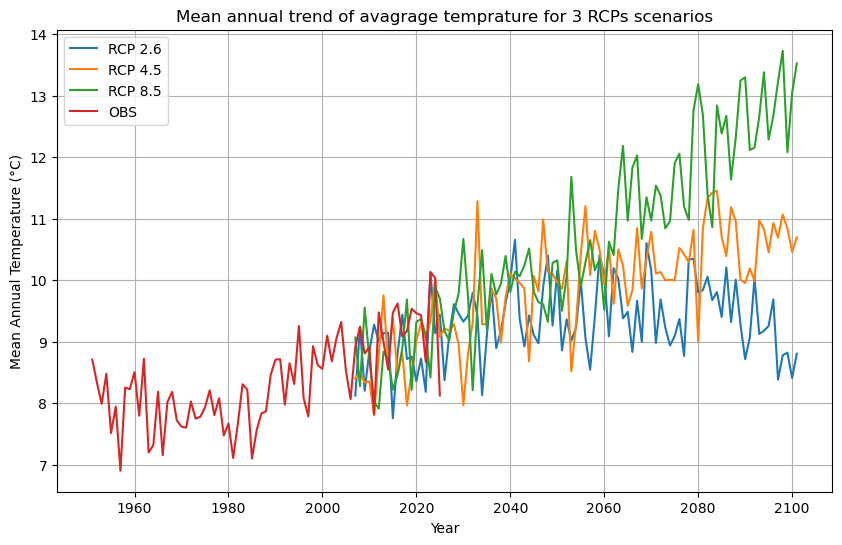

In [10]:
# Visualization of general trend over the total area
plt.figure(figsize=(10, 6))

plt.plot(tas_annual_mean_26.time, tas_annual_mean_26, label="RCP 2.6")
plt.plot(tas_annual_mean_45.time, tas_annual_mean_45, label="RCP 4.5")
plt.plot(tas_annual_mean_85.time, tas_annual_mean_85, label="RCP 8.5")
plt.plot(tas_annual_mean_obs.time, tas_annual_mean_obs, label="OBS")

plt.xlabel("Year")
plt.ylabel("Mean Annual Temperature (°C)")
plt.title("Mean annual trend of avagrage temprature for 3 RCPs scenarios")
plt.legend()
plt.grid(True)
plt.show()

### Spatial temperature change compared to observed values

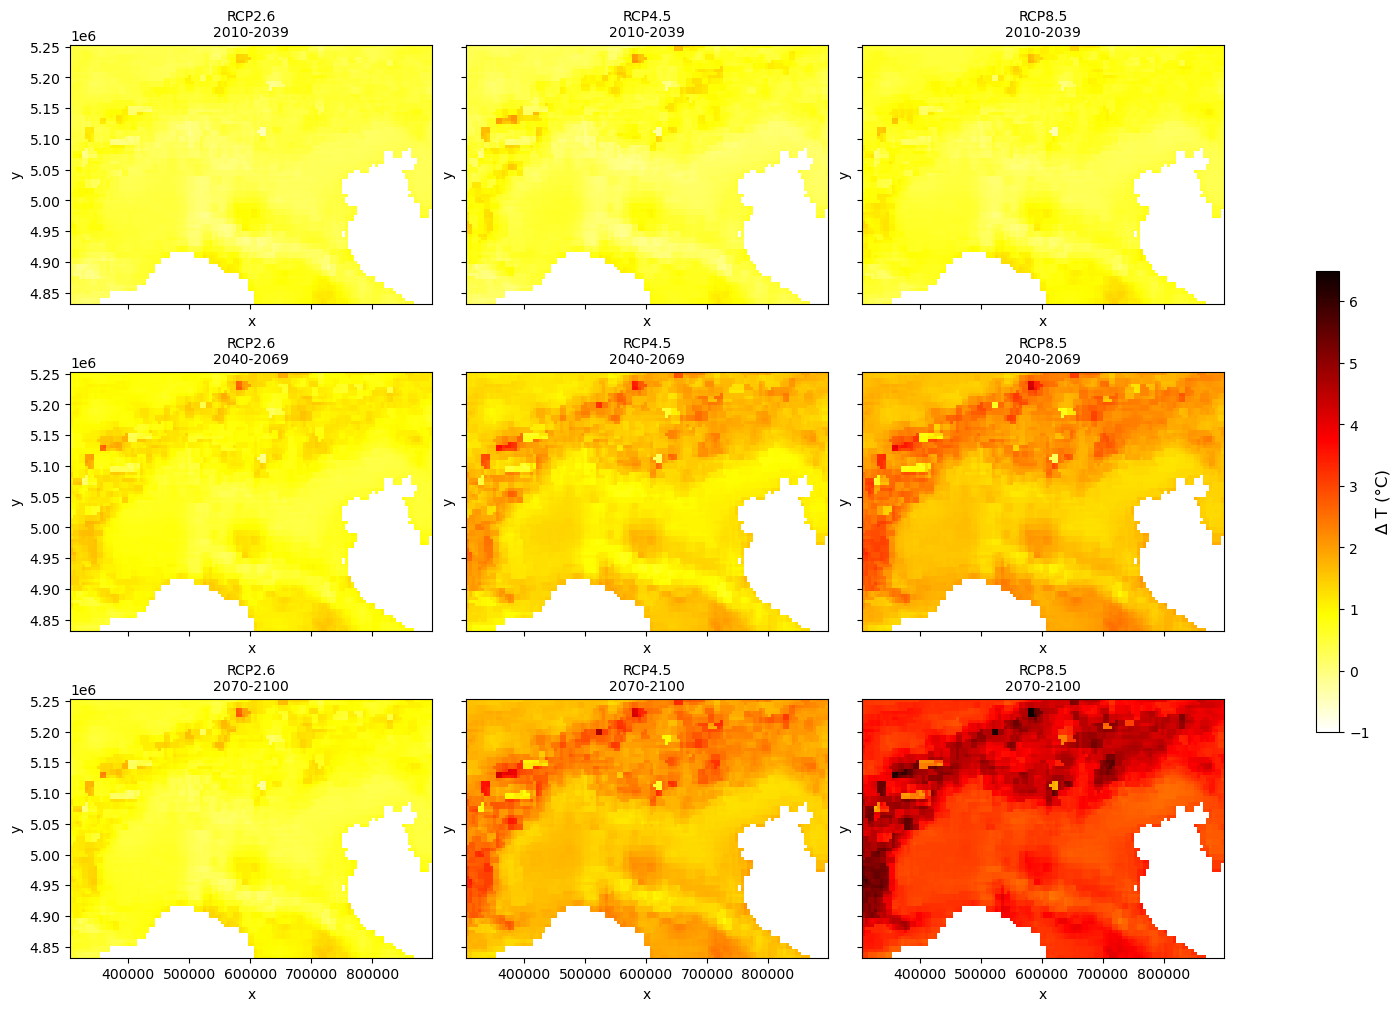

In [27]:
obs_renamed = ds_obs.rename({'Easting': 'x', 'Northing': 'y'})

# Calcola la media osservata (1980–2023) e carica in RAM
obs_period_mean = obs_renamed['tg'].sel(time=slice("1980", "2023")).mean(dim='time').load()

# Definisci scenari RCP e dataset associati
rcps = [
    ("RCP2.6", ds_rcp26),
    ("RCP4.5", ds_rcp45),
    ("RCP8.5", ds_rcp85)
]

# Definisci i periodi temporali
periods = [
    ("2010-2039", "2010", "2039"),
    ("2040-2069", "2040", "2069"),
    ("2070-2100", "2070", "2099")
]

# Precalcola le medie RCP per ogni periodo
rcp_means = {}
for rcp_label, ds_rcp in rcps:
    rcp_means[rcp_label] = {}
    for period_label, start, end in periods:
        mean_val = ds_rcp['tas'].sel(time=slice(start, end)).mean(dim='time') - 273.15
        rcp_means[rcp_label][period_label] = mean_val.load()

# Calcola maschera valida globale (dove OBS ha dati)
valid_mask = ~np.isnan(obs_period_mean)

# Imposta limiti comuni per la colorbar
vmin = -1
vmax = 6.5

# Crea figura
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10),
                         sharex=True, sharey=True, constrained_layout=True)

# Loop sui plot
for i, (period_label, start, end) in enumerate(periods):
    for j, (rcp_label, ds_rcp) in enumerate(rcps):
        ax = axes[i, j]
        
        # Recupera media precalcolata
        rcp_period_mean = rcp_means[rcp_label][period_label]
        
        # Maschera i NaN condivisi
        diff_map = xr.where(valid_mask & ~np.isnan(rcp_period_mean),
                            rcp_period_mean - obs_period_mean,
                            np.nan)
        
        # Plot senza colorbar
        im = diff_map.plot(ax=ax, cmap='hot_r', vmin=vmin, vmax=vmax, add_colorbar=False)
        
        ax.set_title(f"{rcp_label}\n{period_label}", fontsize=10)

# Colorbar condivisa coerente
sm = mpl.cm.ScalarMappable(cmap='hot_r', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # necessario per la colorbar standalone
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Δ T (°C)", fontsize=12)

plt.show()

### Seasonal temperature behaviour 

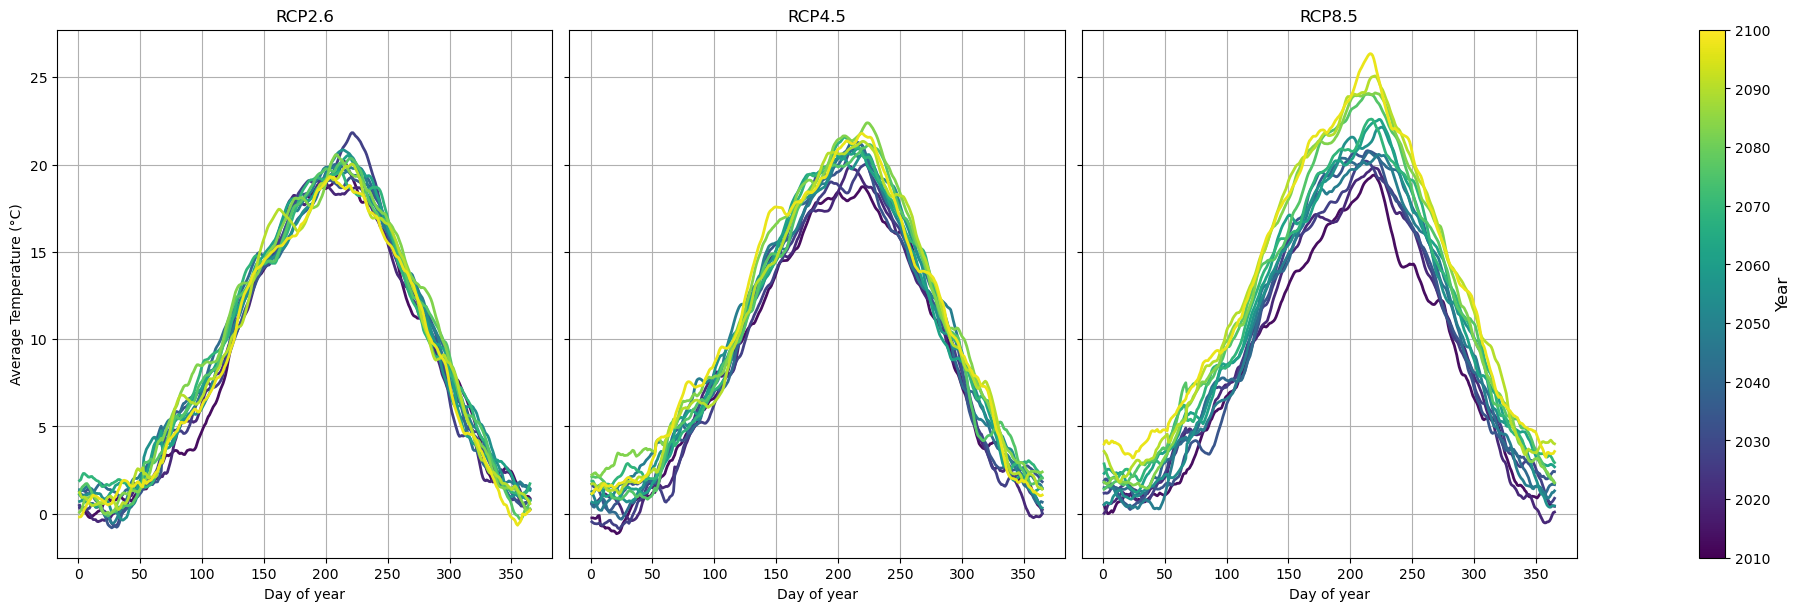

In [17]:
# Parametri iniziali
start_year = 2010
end_year = 2100

scenarios = {
    "RCP2.6": ds_rcp26,
    "RCP4.5": ds_rcp45,
    "RCP8.5": ds_rcp85
}

# Colormap e normalizzazione anni centrali
cmap = plt.colormaps.get_cmap("viridis")
n_blocks = int(np.ceil((end_year - start_year + 1) / 7))
norm = plt.Normalize(vmin=start_year, vmax=start_year + n_blocks * 7 - 1)

# Setup figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True, constrained_layout=True)

for ax, (label, ds) in zip(axes, scenarios.items()):
    # Carica temperatura media giornaliera su tutta l’area (convertita in °C)
    ts = (ds['tas']
          .sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
          .mean(dim=['x', 'y']) - 273.15).load()
    
    # Media mobile su 15 giorni
    ts_smooth = ts.rolling(time=15, center=True).mean()
    
    # Calcola blocchi di 7 anni
    years = ts_smooth['time'].dt.year
    blocks = ((years - start_year) // 7).astype(int)
    ts_smooth = ts_smooth.assign_coords(block=("time", blocks.data))

    # Raggruppa per blocco
    for block_id, da in ts_smooth.groupby("block"):
        if da.time.size == 0:
            continue  # salta blocchi vuoti

        # Rimuovi 29 febbraio per uniformità
        da = da.where(da.time.dt.dayofyear != 366, drop=True)

        # Media stagionale giornaliera
        daily_cycle = da.groupby("time.dayofyear").mean(dim="time")

        # Calcola anno centrale del blocco
        central_year = start_year + block_id * 7 + 3
        color = cmap(norm(central_year))

        # Plot linea
        ax.plot(daily_cycle["dayofyear"], daily_cycle.values,
                linewidth=2, color=color,
                label=f"{start_year + block_id * 7}-{min(start_year + block_id * 7 + 6, end_year)}")

    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Day of year")
    ax.grid(True)

axes[0].set_ylabel("Average Temperature (°C)")

# Colorbar comune
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Year", fontsize=12)

plt.show()

In [ ]:
del tas_annual_mean_26, tas_annual_mean_45, tas_annual_mean_85, obs_annual_mean_85
del ds_rcp26, ds_rcp45, ds_rcp85, ds_obs

## T max

In [5]:
# Data load
rcp26_files = sorted(glob.glob(f"{data_path}\*tasmax*rcp26*.nc"))
rcp45_files = sorted(glob.glob(f"{data_path}\*tasmax*rcp45*.nc"))
rcp85_files = sorted(glob.glob(f"{data_path}\*tasmax*rcp85*.nc"))

obs = sorted(glob.glob(f"{data_path}\*E-OBS*max_temp*.nc"))

In [7]:
ds_rcp26 = xr.open_mfdataset(
    rcp26_files,
    combine='by_coords',
    #chunks={"time": 1825}   # Esempio: 1 anno per chunk
).load()

ds_rcp45 = xr.open_mfdataset(
    rcp45_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_rcp85 = xr.open_mfdataset(
    rcp85_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_obs = xr.open_mfdataset(
    obs,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### T max annual avarage

In [9]:
# Mean on spatial domain (lat e lon)
tas_spatial_mean_26 = ds_rcp26["tasmax"].mean(dim=["y","x"])
tas_spatial_mean_45 = ds_rcp45["tasmax"].mean(dim=["y","x"])
tas_spatial_mean_85 = ds_rcp85["tasmax"].mean(dim=["y","x"])
tas_spatial_mean_obs = ds_obs["tx"].mean(dim=["Easting","Northing"])

# Annual Mean
tas_annual_mean_26 = tas_spatial_mean_26.resample(time="1Y").mean() -273.15
tas_annual_mean_45 = tas_spatial_mean_45.resample(time="1Y").mean() -273.15
tas_annual_mean_85 = tas_spatial_mean_85.resample(time="1Y").mean() -273.15
tas_annual_mean_obs = tas_spatial_mean_obs.resample(time="1Y").mean() 

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


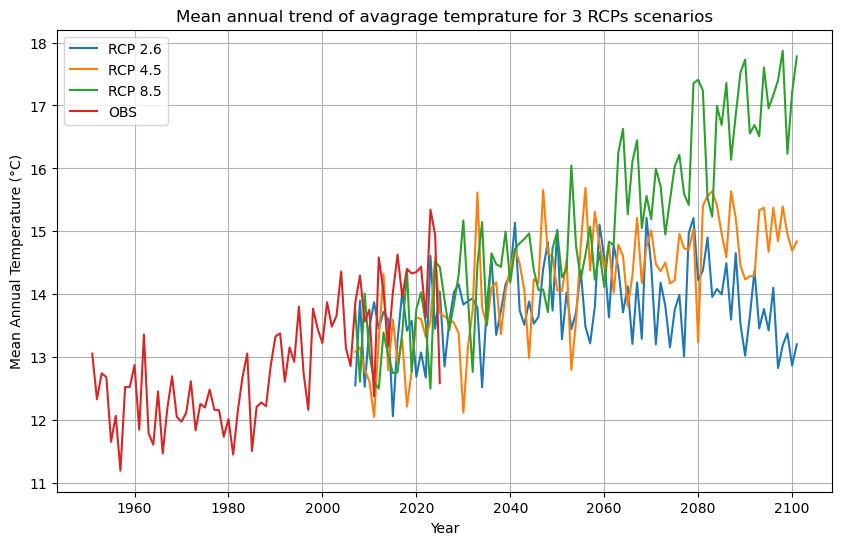

In [15]:
# Visualization of general trend
plt.figure(figsize=(10, 6))

plt.plot(tas_annual_mean_26.time, tas_annual_mean_26, label="RCP 2.6")
plt.plot(tas_annual_mean_45.time, tas_annual_mean_45, label="RCP 4.5")
plt.plot(tas_annual_mean_85.time, tas_annual_mean_85, label="RCP 8.5")
plt.plot(tas_annual_mean_obs.time, tas_annual_mean_obs, label="OBS")

plt.xlabel("Year")
plt.ylabel("Mean Annual Temperature (°C)")
plt.title("Mean annual trend of avagrage temprature for 3 RCPs scenarios")
plt.legend()
plt.grid(True)
plt.show()

### T max variation compared to observed values

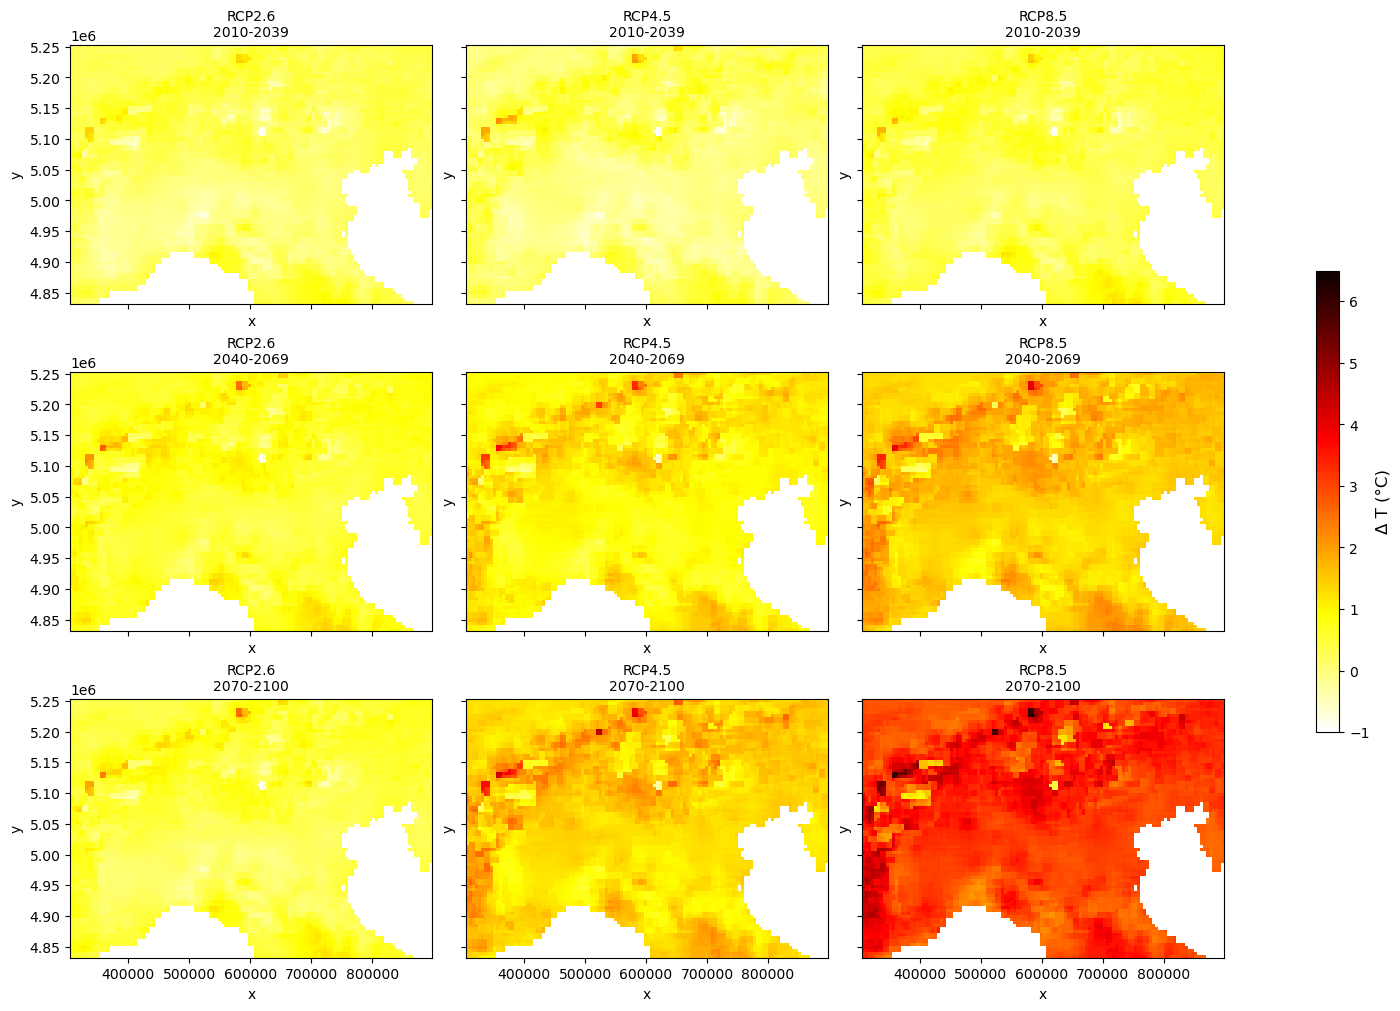

In [11]:
obs_renamed = ds_obs.rename({'Easting': 'x', 'Northing': 'y'})

# Calcola la media osservata (1980–2023) e carica in RAM
obs_period_mean = obs_renamed['tx'].sel(time=slice("1980", "2023")).mean(dim='time').load()

# Definisci scenari RCP e dataset associati
rcps = [
    ("RCP2.6", ds_rcp26),
    ("RCP4.5", ds_rcp45),
    ("RCP8.5", ds_rcp85)
]

# Definisci i periodi temporali
periods = [
    ("2010-2039", "2010", "2039"),
    ("2040-2069", "2040", "2069"),
    ("2070-2100", "2070", "2099")
]

# Precalcola le medie RCP per ogni periodo
rcp_means = {}
for rcp_label, ds_rcp in rcps:
    rcp_means[rcp_label] = {}
    for period_label, start, end in periods:
        mean_val = ds_rcp['tasmax'].sel(time=slice(start, end)).mean(dim='time') - 273.15
        rcp_means[rcp_label][period_label] = mean_val.load()

# Calcola maschera valida globale (dove OBS ha dati)
valid_mask = ~np.isnan(obs_period_mean)

# Imposta limiti comuni per la colorbar
vmin = -1
vmax = 6.5

# Crea figura
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10),
                         sharex=True, sharey=True, constrained_layout=True)

# Loop sui plot
for i, (period_label, start, end) in enumerate(periods):
    for j, (rcp_label, ds_rcp) in enumerate(rcps):
        ax = axes[i, j]
        
        # Recupera media precalcolata
        rcp_period_mean = rcp_means[rcp_label][period_label]
        
        # Maschera i NaN condivisi
        diff_map = xr.where(valid_mask & ~np.isnan(rcp_period_mean),
                            rcp_period_mean - obs_period_mean,
                            np.nan)
        
        # Plot senza colorbar
        im = diff_map.plot(ax=ax, cmap='hot_r', vmin=vmin, vmax=vmax, add_colorbar=False)
        
        ax.set_title(f"{rcp_label}\n{period_label}", fontsize=10)

# Colorbar condivisa coerente
sm = mpl.cm.ScalarMappable(cmap='hot_r', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # necessario per la colorbar standalone
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Δ T (°C)", fontsize=12)

plt.show()

### Seasonal behaviour

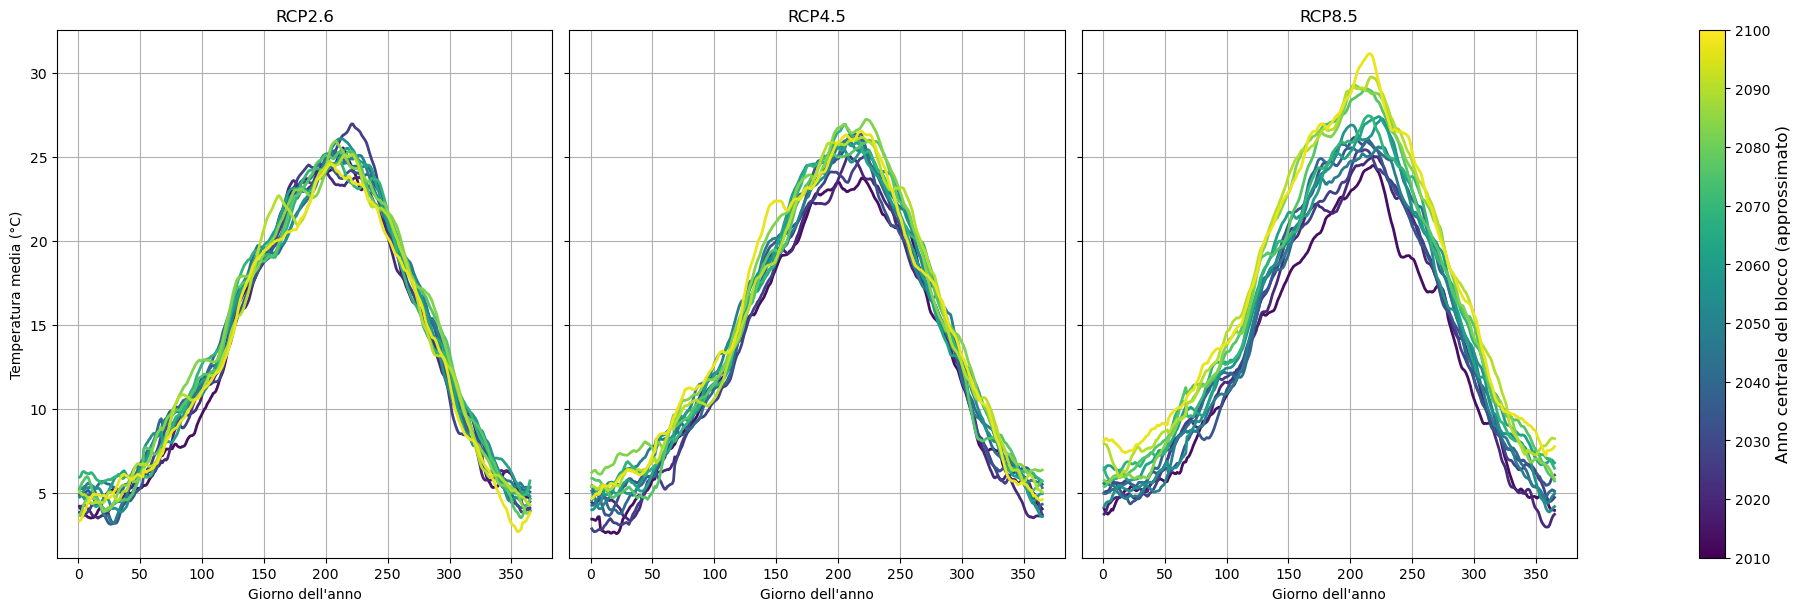

In [61]:
# Set time and scenarios
start_year = 2010
end_year = 2100

scenarios = {
    "RCP2.6": ds_rcp26,
    "RCP4.5": ds_rcp45,
    "RCP8.5": ds_rcp85
}

#'viridis'
cmap = plt.colormaps.get_cmap("viridis")

# Set 7 years block
n_blocks = int(np.ceil((end_year - start_year + 1) / 7.0))
norm = plt.Normalize(vmin=start_year, vmax=start_year + n_blocks * 7 - 1)

# 3 subplot (one per RCPs)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6), sharey=True, constrained_layout=True)

for ax, (label, ds) in zip(axes, scenarios.items()):
    # Select period and convert to °C
    ts = ds['tasmax'].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim=['x','y']) - 273.15
    # Moving average su 15 giorni
    ts_smooth = ts.rolling(time=15, center=True).mean()
    
    # Create the coordinate Block
    block = ((ts_smooth.time.dt.year.values - start_year) // 7)
    ts_smooth = ts_smooth.assign_coords(block=("time", block))
    
    # Group per 7 years
    groups = ts_smooth.groupby("block")
    
    for b, da in groups:
        # Revome leap day
        da = da.where(da.time.dt.dayofyear != 366, drop=True)
        # Group by day of the year for ciclostationary mean
        daily_cycle = da.groupby("time.dayofyear").mean(dim="time")
        
        # Extract day of year
        doy = daily_cycle.coords["dayofyear"].values
        temp_values = daily_cycle.values
        
        # Compute middle year
        central_year = start_year + b * 7 + 3
        color = cmap(norm(central_year))
        
        ax.plot(doy, temp_values, linewidth=2, color=color, 
                label=f"{int(start_year + b * 7)}-{min(int(start_year + b * 7 + 6), end_year)}")
    
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Day of year")
    ax.grid(True)
    #ax.legend(fontsize=8)

axes[0].set_ylabel("Max Temperature (°C)")

# Ccolorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Year", fontsize=12)

plt.show()

In [17]:
del tas_annual_mean_26, tas_annual_mean_45, tas_annual_mean_85, obs_annual_mean
del ds_rcp26, ds_rcp45, ds_rcp85, ds_obs

## Precipitation 

In [19]:
# Data Load 
rcp26_files = sorted(glob.glob(f"{data_path}\*pr*rcp26*.nc"))
rcp45_files = sorted(glob.glob(f"{data_path}\*pr*rcp45*.nc"))
rcp85_files = sorted(glob.glob(f"{data_path}\*pr*rcp85*.nc"))

obs = sorted(glob.glob(f"{data_path}\*EURO4M*.nc"))

In [40]:
ds_rcp26 = xr.open_mfdataset(
    rcp26_files,
    combine='by_coords',
    #chunks={"time": 1825}   
).load()

ds_rcp45 = xr.open_mfdataset(
    rcp45_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_rcp85 = xr.open_mfdataset(
    rcp85_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_obs = xr.open_mfdataset(
    obs,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

### Yearly cumulative precipitation

In [42]:
# Conversion to mm
ds_rcp26 = ds_rcp26*86400
ds_rcp45 = ds_rcp45*86400
ds_rcp85 = ds_rcp85*86400
ds_obs = ds_obs*86400

# Cumulative on spatial domain (lat e lon)
pr_spatial_mean_26 = ds_rcp26["pr"].sum(dim=["y","x"])
pr_spatial_mean_45 = ds_rcp45["pr"].sum(dim=["y","x"])
pr_spatial_mean_85 = ds_rcp85["pr"].sum(dim=["y","x"])
pr_spatial_mean_obs = ds_obs["pr"].sum(dim=["Easting","Northing"])

# Annual Total 
pr_annual_mean_26 = pr_spatial_mean_26.resample(time="1Y").sum()
pr_annual_mean_45 = pr_spatial_mean_45.resample(time="1Y").sum()
pr_annual_mean_85 = pr_spatial_mean_85.resample(time="1Y").sum()
pr_annual_mean_obs = pr_spatial_mean_obs.resample(time="1Y").sum() 

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


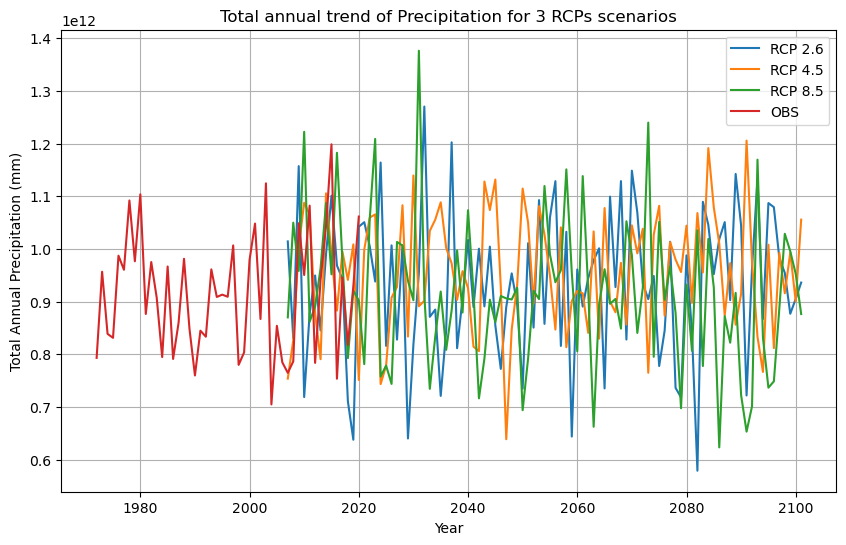

In [44]:
# Visualization of general trend
plt.figure(figsize=(10, 6))

plt.plot(pr_annual_mean_26.time, pr_annual_mean_26, label="RCP 2.6")
plt.plot(pr_annual_mean_45.time, pr_annual_mean_45, label="RCP 4.5")
plt.plot(pr_annual_mean_85.time, pr_annual_mean_85, label="RCP 8.5")
plt.plot(pr_annual_mean_obs.time, pr_annual_mean_obs, label="OBS")

plt.xlabel("Year")
plt.ylabel("Total Annual Precipitation (mm)")
plt.title("Total annual trend of Precipitation for 3 RCPs scenarios")
plt.legend()
plt.grid(True)
plt.show()

### Spatial precipitation variation compared to historical data

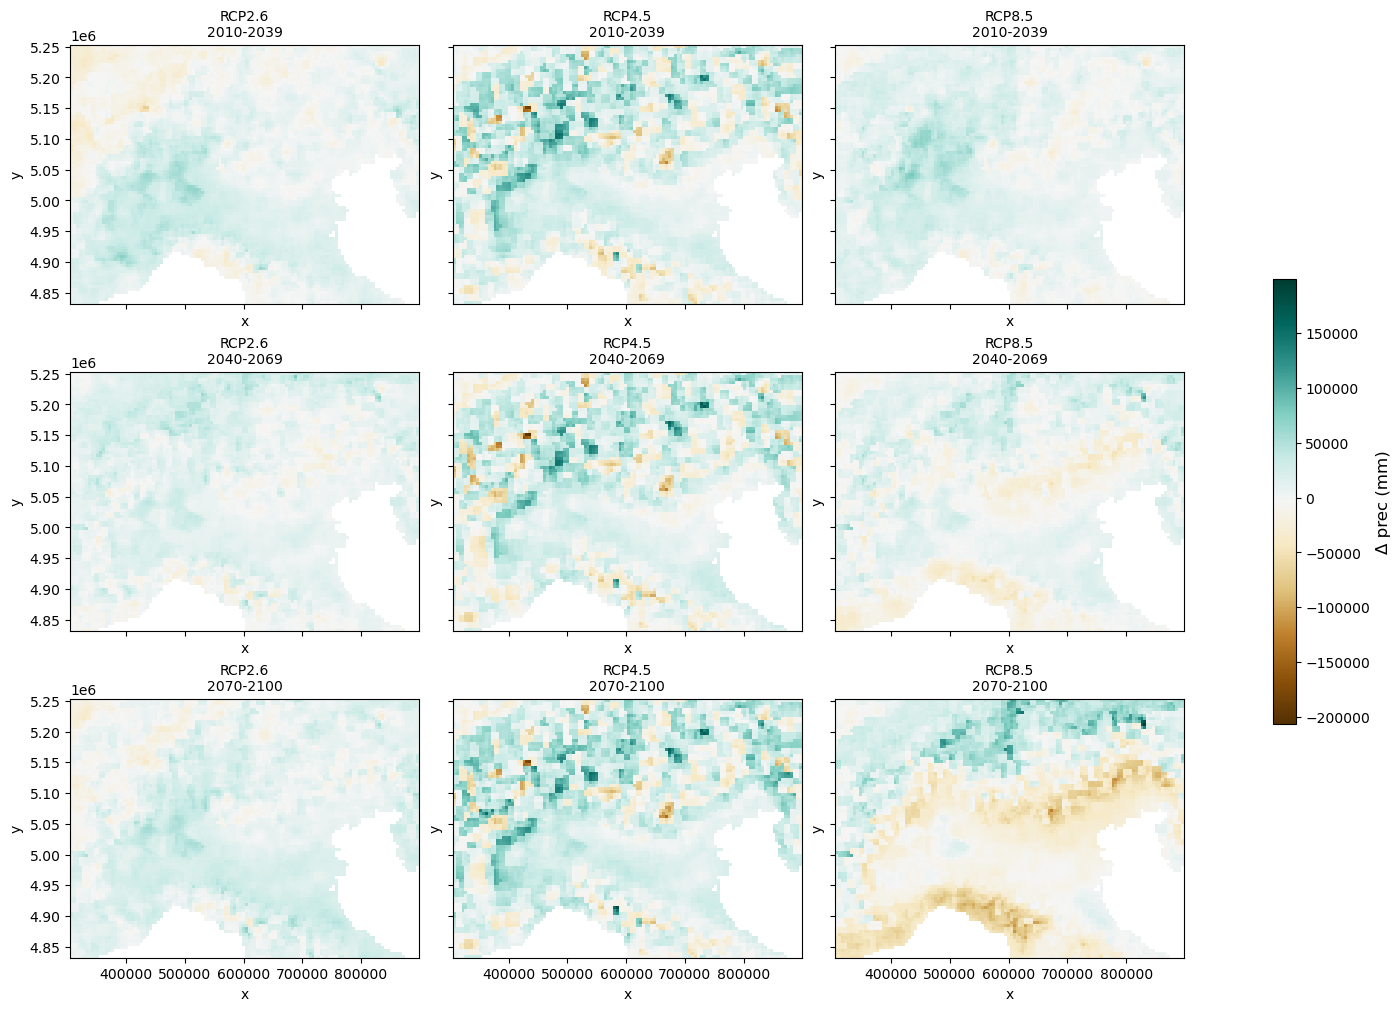

In [50]:
# compute observed mean (1980–2019) and load on RAM
obs_renamed = ds_obs.rename({'Easting': 'x', 'Northing': 'y'})
obs_period_mean = obs_renamed['pr'].sel(time=slice("1980", "2019")).mean(dim='time').load()

# Define scenarios
rcps = [
    ("RCP2.6", ds_rcp26),
    ("RCP4.5", ds_rcp45),
    ("RCP8.5", ds_rcp85)
]

# Define time slices 
periods = [
    ("2010-2039", "2010", "2039"),
    ("2040-2069", "2040", "2069"),
    ("2070-2100", "2070", "2099")
]

# compute means 
rcp_means = {}
all_diffs = []

for rcp_label, ds_rcp in rcps:
    rcp_means[rcp_label] = {}
    for period_label, start, end in periods:
        mean_val = ds_rcp['pr'].sel(time=slice(start, end)).mean(dim='time').load()
        rcp_means[rcp_label][period_label] = mean_val
        
        # Difference compared with observed 
        diff = xr.where(~np.isnan(obs_period_mean) & ~np.isnan(mean_val), mean_val - obs_period_mean, np.nan)
        all_diffs.append(diff)

# compute limits for colorbar
combined_diff = xr.concat(all_diffs, dim='dummy')  # dummy dimension for concat
vmin = float(combined_diff.min(skipna=True))
vmax = float(combined_diff.max(skipna=True))

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10),
                         sharex=True, sharey=True, constrained_layout=True)

# Loop on plot
for i, (period_label, start, end) in enumerate(periods):
    for j, (rcp_label, ds_rcp) in enumerate(rcps):
        ax = axes[i, j]
        
        # Recupera media precalcolata
        rcp_period_mean = rcp_means[rcp_label][period_label]
        
        # Maschera i NaN condivisi
        diff_map = xr.where(~np.isnan(obs_period_mean) & ~np.isnan(rcp_period_mean),
                            rcp_period_mean - obs_period_mean,
                            np.nan)
        
        # Plot senza colorbar
        im = diff_map.plot(ax=ax, cmap='BrBG', vmin=vmin, vmax=vmax, add_colorbar=False)
        
        ax.set_title(f"{rcp_label}\n{period_label}", fontsize=10)

# Colorbar shared 
sm = mpl.cm.ScalarMappable(cmap='BrBG', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Δ prec (mm)", fontsize=12)

plt.show()

### Seasonal behaviour

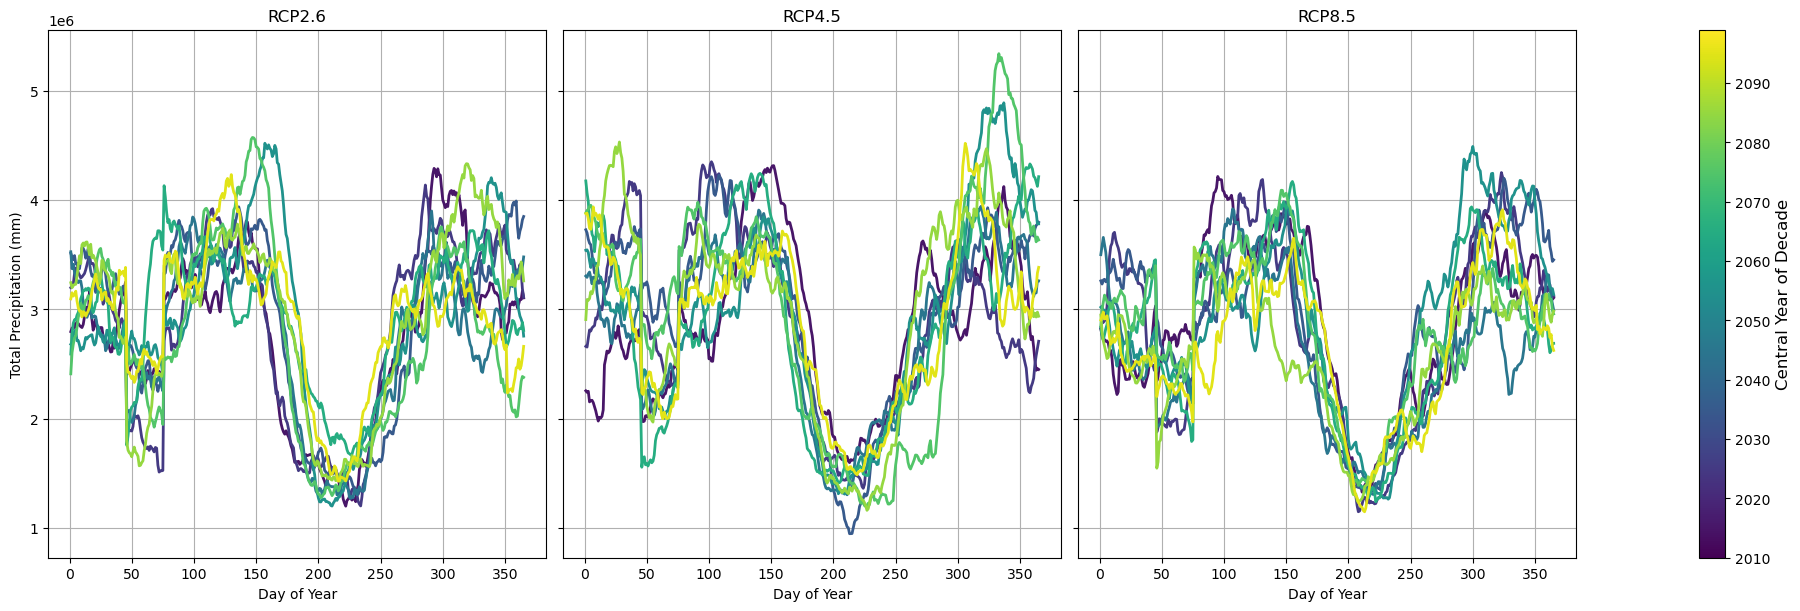

In [60]:
# Set start and end year for analysis
start_year = 2010
end_year = 2099

# Define scenarios and corresponding datasets
scenarios = {
    "RCP2.6": ds_rcp26,
    "RCP4.5": ds_rcp45,
    "RCP8.5": ds_rcp85
}

# Set colormap (viridis) and normalization for colorbar
cmap = plt.colormaps.get_cmap("viridis")
n_blocks = int(np.ceil((end_year - start_year + 1) / 10.0))  # number of 10-year periods
norm = plt.Normalize(vmin=start_year, vmax=start_year + n_blocks * 10 - 1)

# Create one subplot per scenario
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True, constrained_layout=True)

# Loop over each scenario and its dataset
for ax, (label, ds) in zip(axes, scenarios.items()):
    # Select time period and average over spatial dimensions (x, y)
    ts = ds['pr'].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim=['x', 'y'])
    
    # Apply 30-day rolling average to smooth the time series
    ts_smooth = ts.rolling(time=30, center=True).mean()
    
    # Assign "block" coordinate to each time step based on 10-year periods
    block = ((ts_smooth.time.dt.year.values - start_year) // 10)
    ts_smooth = ts_smooth.assign_coords(block=("time", block))
    
    # Group the smoothed time series by 10-year blocks
    groups = ts_smooth.groupby("block")
    
    for b, da in groups:
        # Skip empty groups
        if da.time.size == 0:
            continue

        # Remove leap day (Feb 29) to have consistent 365-day cycles
        da = da.where(da.time.dt.dayofyear != 366, drop=True)
        
        # Group by day of year and sum to get total precipitation cycle
        daily_cycle = da.groupby("time.dayofyear").sum(dim="time")
        
        # Extract day of year and values for plotting
        doy = daily_cycle.coords["dayofyear"].values
        temp_values = daily_cycle.values
        
        # Estimate central year of the 10-year block (e.g., 2015 for 2010–2019)
        central_year = start_year + b * 10 + 5
        color = cmap(norm(central_year))
        
        # Plot seasonal cycle for this block
        ax.plot(doy, temp_values, linewidth=2, color=color, 
                label=f"{int(start_year + b * 10)}–{min(int(start_year + b * 10 + 9), end_year)}")
    
    # Add axis titles and grid
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Day of Year")
    ax.grid(True)

# Y-axis label only for first subplot
axes[0].set_ylabel("Total Precipitation (mm)")

# Add shared colorbar for year encoding
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Central Year of Decade", fontsize=12)

plt.show()

In [63]:
del ds_rcp26, ds_rcp45, ds_rcp85, ds_obs

# Solar Radiation 

In [4]:
# Data Load 
rcp26_files = sorted(glob.glob(f"{data_path}\*rsds*rcp26*.nc"))
rcp45_files = sorted(glob.glob(f"{data_path}\*rsds*rcp45*.nc"))
rcp85_files = sorted(glob.glob(f"{data_path}\*rsds*rcp85*.nc"))

obs = sorted(glob.glob(f"{data_path}\*global_radiation*.nc"))

In [24]:
ds_rcp26 = xr.open_mfdataset(
    rcp26_files,
    combine='by_coords',
    #chunks={"time": 1825}   
).load()

ds_rcp45 = xr.open_mfdataset(
    rcp45_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_rcp85 = xr.open_mfdataset(
    rcp85_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_obs = xr.open_mfdataset(
    obs,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

### Yearly cumulated value

In [26]:
# Conversion to mm
ds_rcp26['rsds'] = ds_rcp26['rsds'] * 24 / 1000  # kWh/m² daily
ds_rcp45['rsds'] = ds_rcp45['rsds'] * 24 / 1000
ds_rcp85['rsds'] = ds_rcp85['rsds'] * 24 / 1000
ds_obs['qq'] = ds_obs['qq'] * 24 / 1000

In [30]:
# Cumulative on spatial domain (lat e lon)
r_spatial_mean_26 = ds_rcp26["rsds"].sum(dim=["y","x"])
r_spatial_mean_45 = ds_rcp45["rsds"].sum(dim=["y","x"])
r_spatial_mean_85 = ds_rcp85["rsds"].sum(dim=["y","x"])
r_spatial_mean_obs = ds_obs["qq"].sum(dim=["Easting","Northing"])

# Annual Total 
r_annual_mean_26 = r_spatial_mean_26.resample(time="1Y").sum()
r_annual_mean_45 = r_spatial_mean_45.resample(time="1Y").sum()
r_annual_mean_85 = r_spatial_mean_85.resample(time="1Y").sum()
r_annual_mean_obs = r_spatial_mean_obs.sel(time=slice(None, "2022-12-31")).resample(time="1Y").sum()

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


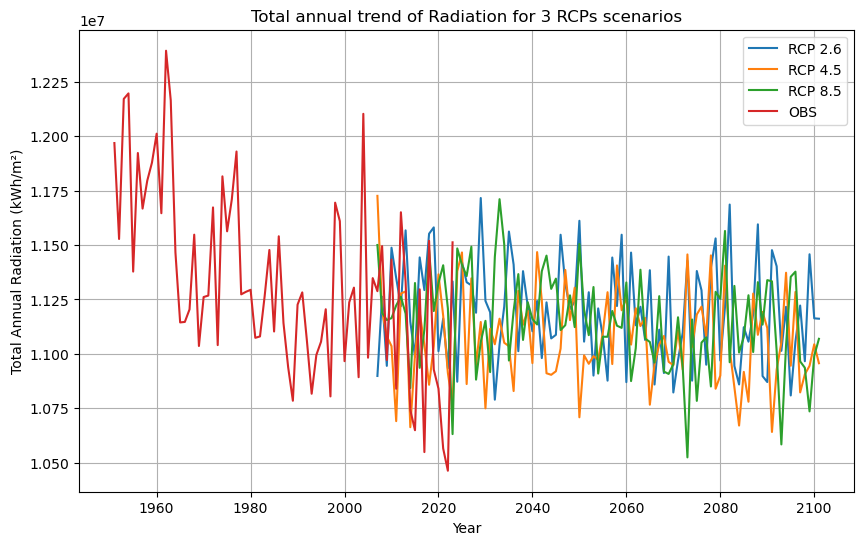

In [32]:
# Visualization of general trend
plt.figure(figsize=(10, 6))

plt.plot(r_annual_mean_26.time, r_annual_mean_26, label="RCP 2.6")
plt.plot(r_annual_mean_45.time, r_annual_mean_45, label="RCP 4.5")
plt.plot(r_annual_mean_85.time, r_annual_mean_85, label="RCP 8.5")
plt.plot(r_annual_mean_obs.time, r_annual_mean_obs, label="OBS")

plt.xlabel("Year")
plt.ylabel("Total Annual Radiation (kWh/m²)")
plt.title("Total annual trend of Radiation for 3 RCPs scenarios")
plt.legend()
plt.grid(True)
plt.show()

## Changes from historical 

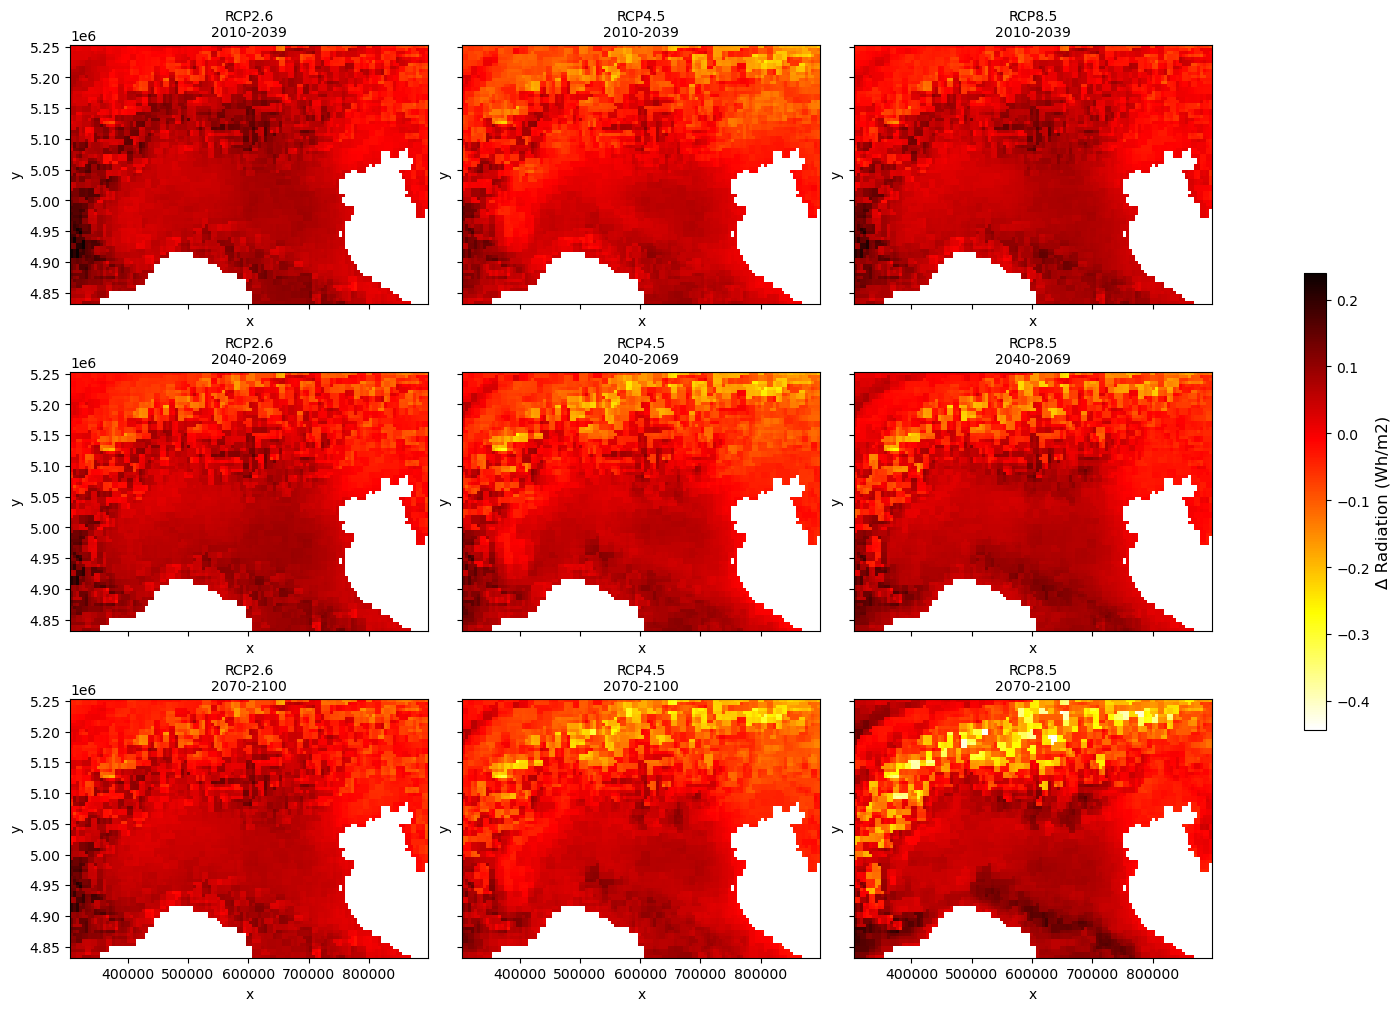

In [35]:
obs_renamed = ds_obs.rename({'Easting': 'x', 'Northing': 'y'})

# Calcola la media osservata (1980–2023) e carica in RAM
obs_period_mean = obs_renamed['qq'].sel(time=slice("1980", "2022")).mean(dim='time').load()

# Definisci scenari RCP e dataset associati
rcps = [
    ("RCP2.6", ds_rcp26),
    ("RCP4.5", ds_rcp45),
    ("RCP8.5", ds_rcp85)
]

# Definisci i periodi temporali
periods = [
    ("2010-2039", "2010", "2039"),
    ("2040-2069", "2040", "2069"),
    ("2070-2100", "2070", "2099")
]

# compute means 
rcp_means = {}
all_diffs = []

for rcp_label, ds_rcp in rcps:
    rcp_means[rcp_label] = {}
    for period_label, start, end in periods:
        mean_val = ds_rcp['rsds'].sel(time=slice(start, end)).mean(dim='time').load()
        rcp_means[rcp_label][period_label] = mean_val
        
        # Difference compared with observed 
        diff = xr.where(~np.isnan(obs_period_mean) & ~np.isnan(mean_val), mean_val - obs_period_mean, np.nan)
        all_diffs.append(diff)

# compute limits for colorbar
combined_diff = xr.concat(all_diffs, dim='dummy')  # dummy dimension for concat
vmin = float(combined_diff.min(skipna=True))
vmax = float(combined_diff.max(skipna=True))

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10),
                         sharex=True, sharey=True, constrained_layout=True)

# Loop on plot
for i, (period_label, start, end) in enumerate(periods):
    for j, (rcp_label, ds_rcp) in enumerate(rcps):
        ax = axes[i, j]
        
        # Recupera media precalcolata
        rcp_period_mean = rcp_means[rcp_label][period_label]
        
        # Maschera i NaN condivisi
        diff_map = xr.where(~np.isnan(obs_period_mean) & ~np.isnan(rcp_period_mean),
                            rcp_period_mean - obs_period_mean,
                            np.nan)
        
        # Plot senza colorbar
        im = diff_map.plot(ax=ax, cmap='hot_r', vmin=vmin, vmax=vmax, add_colorbar=False)
        
        ax.set_title(f"{rcp_label}\n{period_label}", fontsize=10)

# Colorbar shared 
sm = mpl.cm.ScalarMappable(cmap='hot_r', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Δ Radiation (Wh/m2)", fontsize=12)

plt.show()

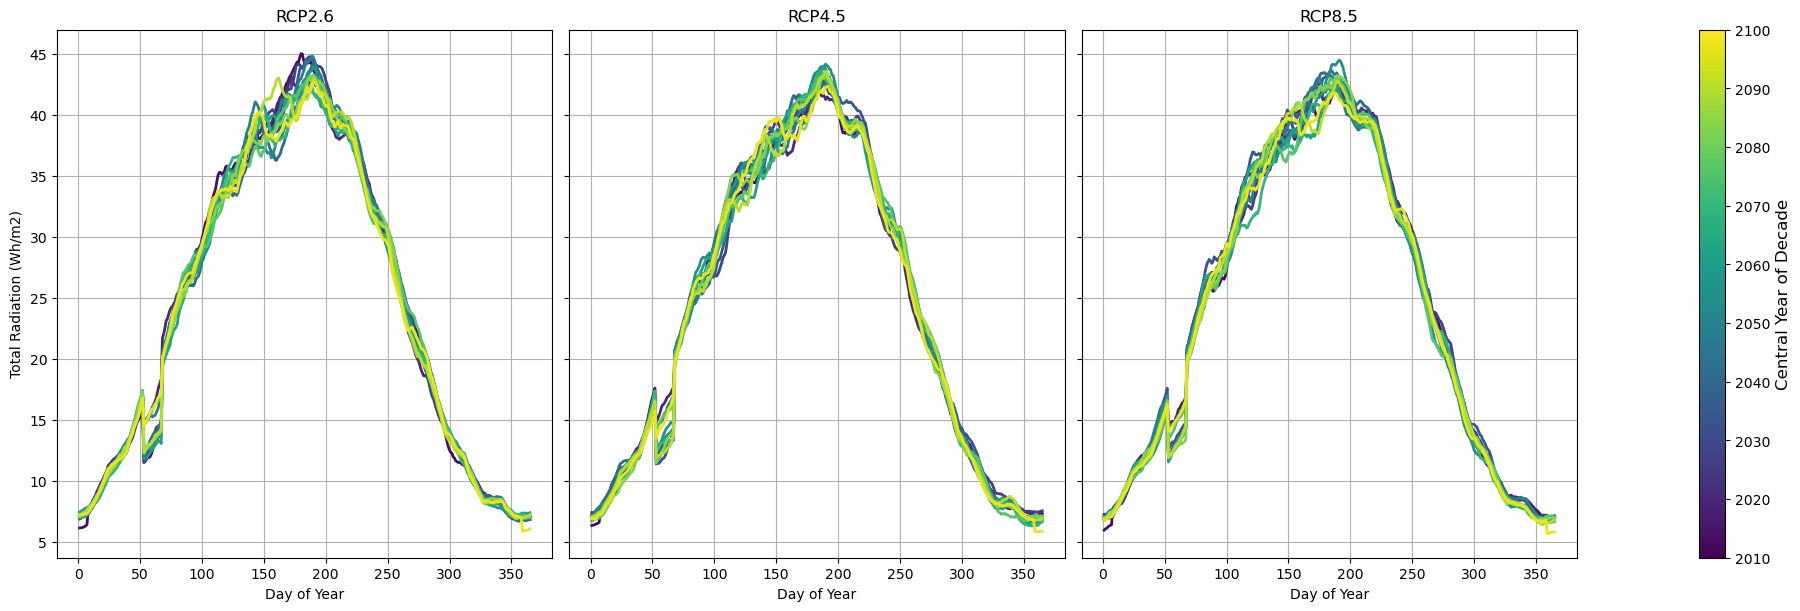

In [39]:
# Set start and end year for analysis
start_year = 2010
end_year = 2100

# Define scenarios and corresponding datasets
scenarios = {
    "RCP2.6": ds_rcp26,
    "RCP4.5": ds_rcp45,
    "RCP8.5": ds_rcp85
}

# Set colormap (viridis) and normalization for colorbar
cmap = plt.colormaps.get_cmap("viridis")
n_blocks = int(np.ceil((end_year - start_year + 1) / 7.0))  # number of 10-year periods
norm = plt.Normalize(vmin=start_year, vmax=start_year + n_blocks * 7 - 1)

# Create one subplot per scenario
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True, constrained_layout=True)

# Loop over each scenario and its dataset
for ax, (label, ds) in zip(axes, scenarios.items()):
    # Select time period and average over spatial dimensions (x, y)
    ts = ds['rsds'].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim=['x', 'y'])
    
    # Apply 30-day rolling average to smooth the time series
    ts_smooth = ts.rolling(time=15, center=True).mean()
    
    # Assign "block" coordinate to each time step based on 10-year periods
    block = ((ts_smooth.time.dt.year.values - start_year) // 7)
    ts_smooth = ts_smooth.assign_coords(block=("time", block))
    
    # Group the smoothed time series by 10-year blocks
    groups = ts_smooth.groupby("block")
    
    for b, da in groups:
        # Skip empty groups
        if da.time.size == 0:
            continue

        # Remove leap day (Feb 29) to have consistent 365-day cycles
        da = da.where(da.time.dt.dayofyear != 366, drop=True)
        
        # Group by day of year and sum to get total precipitation cycle
        daily_cycle = da.groupby("time.dayofyear").sum(dim="time")
        
        # Extract day of year and values for plotting
        doy = daily_cycle.coords["dayofyear"].values
        temp_values = daily_cycle.values
        
        # Estimate central year of the 10-year block (e.g., 2015 for 2010–2019)
        central_year = start_year + b * 7 + 3
        color = cmap(norm(central_year))
        
        # Plot seasonal cycle for this block
        ax.plot(doy, temp_values, linewidth=2, color=color, 
                label=f"{int(start_year + b * 7)}–{min(int(start_year + b * 7 + 6), end_year)}")
    
    # Add axis titles and grid
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Day of Year")
    ax.grid(True)

# Y-axis label only for first subplot
axes[0].set_ylabel("Total Radiation (Wh/m2)")

# Add shared colorbar for year encoding
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Central Year of Decade", fontsize=12)

plt.show()